<a href="https://colab.research.google.com/github/cantonioupao/pytorch-video-recognition/blob/master/Solution_Exercise_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Select TF 2.x 
!pip install -q tf-nightly-2.0-preview
import tensorflow as tf

# other imports
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

     |████████████████████████████████| 92.1MB 93.4MB/s 
     |████████████████████████████████| 3.8MB 35.3MB/s 
     |████████████████████████████████| 450kB 67.2MB/s 


In [0]:
# chech the version
tf.__version__

'2.0.0-dev20190926'

In [0]:
# get the dataset
mnist = tf.keras.datasets.mnist
(train_data, _), (test_data, _) = mnist.load_data()

# Let's press the data between 0 and 1 (also TF likes float32 as it runs 
# very efficient on GPUs)
train_data = np.float32(train_data/255.0)
test_data = np.float32(test_data/255.0)

# reshape
train_data = train_data.reshape((-1, 784))
test_data = test_data.reshape((-1, 784))

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Let's us create a TF Model
class StackAutoEncoder(tf.keras.Model):
  """
  This is our stacked autoencoder class
  It builds two simple Keras model for
  the encoder and decoder
  """
  def __init__(self, dims, activation):
    """
    dims: list of dimensions for the stacked auto encoder
    activation: activation function that should be used
    """
    # init the Model class
    super(StackAutoEncoder, self).__init__()
    
    self.encoder = self.build_keras_model(dims, activation,
                                          last_layer_activation=True,
                                          name="Encoder")
    self.decoder = self.build_keras_model([*dims[-2::-1], 28*28], activation,
                                          last_layer_activation=False,
                                          name="Decoder")
    
  def call(self, x):
    """
    Forward pass of the network
    x: input
    """
    x_prime = self.encoder(x)
    x_hat = self.decoder(x_prime)
    
    return x_hat
  
  def build_keras_model(self, dims, activation, last_layer_activation=False,
                        name=None):
    """
    dims: list of dimensions of the FC layers
    activation: activation function of the layers (can be None)
    last_layer_activation: Bool, whether to use the activation for the last
                           layer or not
    name: sting, name of the model (for summaries and checkpoints)
    """
    layers = []
    for dim in dims:
      layers.append(tf.keras.layers.Dense(dim, activation=activation))
    
    
    # remove the last layer activation if demanded
    if not last_layer_activation:
      layers[-1].activation = None

    return tf.keras.Sequential(layers, name=name)
  

In [0]:
# build the model with tanh activation (we compress the data to a vector of length 50)
model = StackAutoEncoder([50], activation=tf.nn.tanh)
# compile the model with mean squared error (mse) loss and Adam
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse')
# fit the model (train for 5 epochs)
history = model.fit(x=train_data, y=train_data, batch_size=64, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 48us/sample - loss: 0.0243
Epoch 2/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0131
Epoch 3/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0125
Epoch 4/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0123
Epoch 5/5
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0122


In [0]:
# Let's check our models summary
model.summary()

Model: "stack_auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder (Sequential)         multiple                  39250     
_________________________________________________________________
Decoder (Sequential)         multiple                  39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_________________________________________________________________


In [0]:
"""
We now want to play around with our model, so we wrap the whole process in a 
function
"""

def build_and_fit(dims, activation=None, name='', remove_old_logs=False):
  # something like reseting the graph
  tf.keras.backend.clear_session()
  
  # We implement a tensorboard callback and monitor the train and test error
  if remove_old_logs:
    try:
      tf.io.gfile.rmtree('logs/scalars')
    except tf.errors.OpError:
      pass
  logdir = "logs/scalars/" + name + datetime.now().strftime("_%Y_%m_%d-%H:%M:%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

  # We build the same model
  model = StackAutoEncoder(dims, activation=activation)
  # compile the model with mean squared error (mse) loss and Adam
  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mse')
  # fit the model (train for 5 epochs)
  model.fit(x=train_data, y=train_data, batch_size=64, epochs=5,
            #verbose=0, # we don't need output anymore
            validation_data=(test_data, test_data), # we also want the test error
            callbacks=[tensorboard_callback])
  return model

In [0]:
# Let's test it
model = build_and_fit([50], activation=tf.nn.tanh, name="SAE_50", remove_old_logs=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0239 - val_loss: 0.0135
Epoch 2/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0131 - val_loss: 0.0124
Epoch 3/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0125 - val_loss: 0.0121
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0123 - val_loss: 0.0118
Epoch 5/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0122 - val_loss: 0.0118


In [0]:
# Let's start up Tensorboard to monitor our loss
# You may need to select "View output fullscreen" 
# If it does not work run the cell again after 30s
%load_ext tensorboard
%tensorboard --logdir logs/scalars

In [0]:
# Do everything with 100 hidden units
model = build_and_fit([100], activation=tf.nn.tanh, name="SAE_100")
# Do everything with 400 and then 100 hidden units
model = build_and_fit([400, 100], activation=tf.nn.tanh, name="SAE_400_100")
# After the cell has run, you should see the losses in Tensorboard above

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0170 - val_loss: 0.0076
Epoch 2/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0070 - val_loss: 0.0064
Epoch 3/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0064 - val_loss: 0.0061
Epoch 4/5
60000/60000 [==============================] - 4s 63us/sample - loss: 0.0062 - val_loss: 0.0061
Epoch 5/5
60000/60000 [==============================] - 4s 62us/sample - loss: 0.0061 - val_loss: 0.0060
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0120 - val_loss: 0.0067
Epoch 2/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0066 - val_loss: 0.0063
Epoch 3/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0064 - val_loss: 0.0063
Epoch 4/5
60000/60000 [==========================

In [0]:
# Do everything with 400, 100 hidden units and ReLu
model = build_and_fit([400, 100], activation=tf.nn.relu, name="ReLU_SAE_400_100")
# Let's go crazy
model = build_and_fit([400, 300, 200, 100], activation=tf.nn.relu, name="ReLU_SAE_400_300_200_100")

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.0173 - val_loss: 0.0105
Epoch 2/5
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0099 - val_loss: 0.0092
Epoch 3/5
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0092 - val_loss: 0.0088
Epoch 4/5
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0089 - val_loss: 0.0085
Epoch 5/5
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0087 - val_loss: 0.0084
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 200us/sample - loss: 0.0233 - val_loss: 0.0139
Epoch 2/5
60000/60000 [==============================] - 12s 192us/sample - loss: 0.0126 - val_loss: 0.0110
Epoch 3/5
60000/60000 [==============================] - 12s 192us/sample - loss: 0.0106 - val_loss: 0.0098
Epoch 4/5
60000/60000 [==================

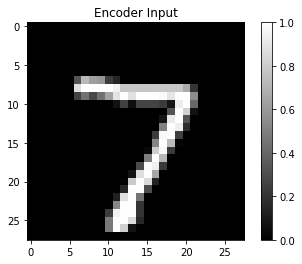

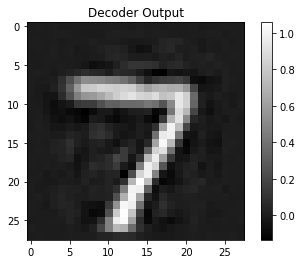

In [0]:
# Lets transform the first image of the test set and plot it
transformed_image = model(test_data[:1]).numpy().reshape((28,28))

# plot
plt.title("Encoder Input")
plt.imshow(test_data[0].reshape((28,28)), cmap=plt.cm.gray)
plt.colorbar()
plt.show()

plt.title("Decoder Output")
plt.imshow(transformed_image, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

In [0]:
# Feel free to use this Notebook to play around!